In [1]:
from utils import *
from utils.utils import calculate_mse
from model import ConformerMSCRED
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from glob import glob
import os
from tqdm import tqdm
import numpy as np

In [135]:
with open('anomaly_test2.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [136]:
X_test, y_test = calculate_signature_matrix_dataset(test_data, lags=[10, 30, 60], stride=1, num_timesteps=5)
X_test = torch.Tensor(X_test.transpose(0, 4, 1, 2, 3))
y_test = torch.Tensor(y_test.transpose(0, 3, 1, 2))
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=4, shuffle=False)

100%|██████████| 2441/2441 [00:01<00:00, 1220.87it/s]


In [137]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConformerMSCRED(device=device).to(device)

model_paths = glob(os.path.join('weights', '*.pt'))
model_paths.sort()
ckpt_path = model_paths[-1]
print(f'Using ckpt : {ckpt_path}')
if device == 'cpu':
    model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
else:
    model.load_state_dict(torch.load(ckpt_path))

Using ckpt : weights/mscred_weights_epoch_15_val_loss_0.4032.pt


In [138]:
outputs = []

with torch.no_grad():
    for batch_x, batch_y in tqdm(test_loader):
        output = model(batch_x.to(device)).detach().cpu().numpy()
        outputs.append(output)
outputs = np.concatenate(outputs, axis=0)

y_test = y_test.cpu().numpy()

100%|██████████| 610/610 [05:11<00:00,  1.96it/s]


이상치 (start, duration)
- 9 14 16   (500, 90)
- 1 5 10    (1000, 30)
- 3 7 13    (1500, 60)
- 4 8 15    (1700, 60)
- 2 6 9 12  (2350, 30)
- 10,5,11          4 (0, 50)

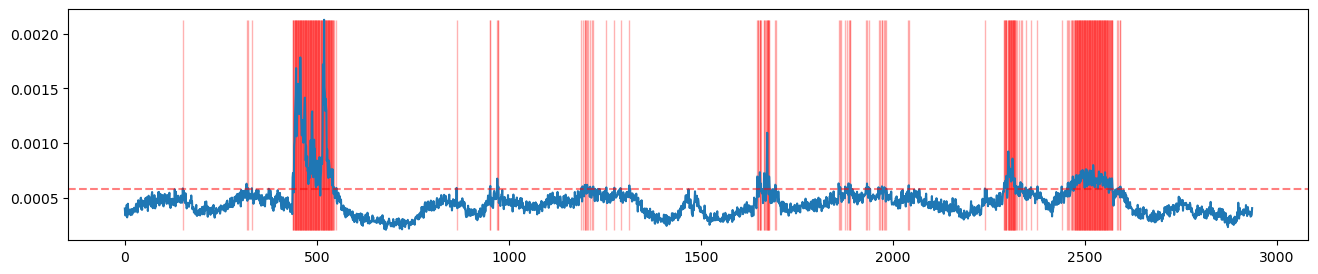

In [130]:
test_mse, _ = calculate_mse(y_test, outputs)
threshold = np.sort(test_mse)[int(-0.108*len(test_mse))]
plt.figure(figsize=(16,3))
plt.plot(test_mse)
plt.axhline(threshold, 0, 2500, alpha=0.5, color='red', linestyle='--')
for idx, val in enumerate(test_mse > threshold):
    if val:
        plt.fill_between(np.arange(idx,idx+1), y1=min(test_mse), y2=max(test_mse), color='red', alpha=0.3)

In [93]:
np.argmax(test_mse)

1492

Text(0.5, 0, 'Total diff : 1.3794')

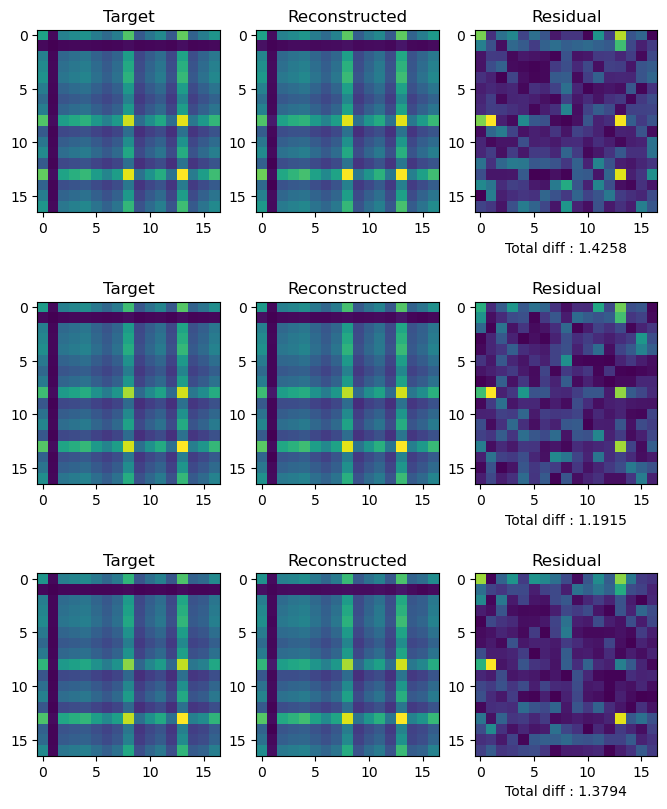

In [95]:
mat_num = 100

fig, ax = plt.subplots(3,3, figsize=(8,10))
ax[0][0].imshow(y_test[mat_num,0,:,:])
ax[0][0].set_title("Target")
ax[0][1].imshow(outputs[mat_num,0,:,:])
ax[0][1].set_title("Reconstructed")
ax[0][2].imshow(abs(outputs[mat_num,0,:,:]-y_test[mat_num,0,:,:]))
ax[0][2].set_title("Residual")
ax[0][2].set_xlabel(f'Total diff : {sum(sum(abs(outputs[mat_num,0,:,:]-y_test[mat_num,0,:,:]))):0.4f}')

ax[1][0].imshow(y_test[mat_num,1,:,:])
ax[1][0].set_title("Target")
ax[1][1].imshow(outputs[mat_num,1,:,:])
ax[1][1].set_title("Reconstructed")
ax[1][2].imshow(abs(outputs[mat_num,1,:,:]-y_test[mat_num,1,:,:]))
ax[1][2].set_title("Residual")
ax[1][2].set_xlabel(f'Total diff : {sum(sum(abs(outputs[mat_num,1,:,:]-y_test[mat_num,1,:,:]))):0.4f}')

ax[2][0].imshow(y_test[mat_num,2,:,:])
ax[2][0].set_title("Target")
ax[2][1].imshow(outputs[mat_num,2,:,:])
ax[2][1].set_title("Reconstructed")
ax[2][2].imshow(abs(outputs[mat_num,2,:,:]-y_test[mat_num,2,:,:]))
ax[2][2].set_title("Residual")
ax[2][2].set_xlabel(f'Total diff : {sum(sum(abs(outputs[mat_num,2,:,:]-y_test[mat_num,2,:,:]))):0.4f}')

In [8]:
# Diagonal 요소 비교

residual1 = abs(outputs[mat_num,0,:,:]-y_test[mat_num,0,:,:])
print(np.argsort(residual1.diagonal())[::-1])
residual2 = abs(outputs[mat_num,1,:,:]-y_test[mat_num,1,:,:])
print(np.argsort(residual2.diagonal())[::-1])
residual3 = abs(outputs[mat_num,2,:,:]-y_test[mat_num,2,:,:])
print(np.argsort(residual3.diagonal())[::-1])

total_resiudal = residual1.diagonal() + residual2.diagonal() + residual3.diagonal()
print(np.argsort(total_resiudal)[::-1])

[ 0 16  4 13  5  2  9 15  6  1  3 11  8 10 14 12  7]
[ 0  4 13  6  3  2  5  7 16  9  1 10 14 11 15  8 12]
[ 0  4 13  5  3  7  2  9  8 14 15  1 10  6 11 16 12]
[ 0  4 13  5 16  2  3  9  6  7  1 15  8 14 10 11 12]


이상치 (start, duration)
- 9 14 16   (500, 90)
- 1 5 10    (1000, 30)
- 3 7 13    (1500, 60)
- 4 8 15    (1700, 60)
- 2 6 9 12  (2350, 30)

- 10,5,11   (0, 50)
- 10, 13, 14, 3 (2125, 150)

### 평가

In [76]:
y_true = np.full((2500), False)
y_true[0:50] = True
y_true[500:590] = True
y_true[1000:1030] = True
y_true[1500:1560] = True
y_true[1700:1760] = True
y_true[2125:2275] = True
y_true[2350:2380] = True

In [77]:
y_true[510]

True

In [78]:
with open('test_true.pkl', 'wb') as f:
    pickle.dump(y_true, f)

In [79]:
with open('test_true.pkl', 'rb') as f:
    y_true = pickle.load(f)

In [10]:
# Precision
predict = test_mse > threshold

In [67]:
predict

array([ True,  True,  True, ..., False, False, False])

In [74]:
predict = np.array(predict)

In [68]:
len(y_true)

2437

In [81]:
dd = np.full((63), False)

In [82]:
predict = np.concatenate([dd, predict])

In [83]:
len(predict)

2500

In [84]:
def find_scores(predict, true):
    tp, fn, tn, fp = 0, 0, 0, 0
    for i in range(len(true)):
        if true[i] == True and predict[i] == True:
            tp += 1
        elif true[i] == True and predict[i] == False:
            fn += 1
        elif true[i] == False and predict[i] == False:
            tn += 1
        elif true[i] == False and predict[i] == True:
            fp += 1

    print(f"tp: {tp}, fn: {fn}, tn: {tn}, fp: {fp}")
    accuracy = (tp + tn) / len(true)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)

    print('accuracy : {:.2f}'.format(accuracy))
    print('precision: {:.2f}'.format(precision))
    print('recall: {:.2f}'.format(recall))
    print('f1: {:.2f}'.format(f1))

In [85]:
find_scores(predict, y_true)

tp: 118, fn: 152, tn: 2086, fp: 144
accuracy : 0.88
precision: 0.45
recall: 0.44
f1: 0.44
